# Imports

In [97]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import wandb

# Config

In [98]:
FEE = 0.00055
WINDOW_SIZE = 64
HIDDEN_SIZES = [64, 64]
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
EPOCHS = 40
DROPOUT_RATE = 0.1
USE_RESIDUALS = True
OUTPUTS = ["BUY", "SELL", "HOLD"]
WANDB = False

# Weights and Biases

In [99]:
if WANDB:
    wandb.init(project="bybit-trading-bot")
    wandb.config.update({
        "fee": FEE,
        "window_size": WINDOW_SIZE,
        "hidden_sizes": HIDDEN_SIZES,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "dropout_rate": DROPOUT_RATE,
        "use_residuals": USE_RESIDUALS,
        "outputs": OUTPUTS
    })

# Preprocess data

In [100]:
from preprocess_data import rates_of_change_categorical, rates_of_change_regression

Xtrain, Ytrain, Xtest_dict, Ytest_dict = rates_of_change_categorical(WINDOW_SIZE, FEE, OUTPUTS, 120)

_, _, _, Ytest_regr_dict = rates_of_change_regression(WINDOW_SIZE, 120)

Xtrain.shape, Ytrain.shape, Xtest_dict["BTCUSDT"].shape, Ytest_dict["BTCUSDT"].shape

[<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


(torch.Size([47030, 64]),
 torch.Size([47030]),
 torch.Size([720, 64]),
 torch.Size([720]))

# Model class

In [101]:
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


class TradingNN(nn.Module):

    def __init__(self):
        super(TradingNN, self).__init__()
        self.fc_input = nn.Linear(WINDOW_SIZE, HIDDEN_SIZES[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(HIDDEN_SIZES) - 1):
            self.hidden_layers.append(
                nn.Linear(HIDDEN_SIZES[i], HIDDEN_SIZES[i + 1]))

        self.fc_output = nn.Linear(HIDDEN_SIZES[-1], len(OUTPUTS))

        self.dropout = nn.Dropout(DROPOUT_RATE)

        self.activation = nn.SiLU()

    def forward(self, x):
        if USE_RESIDUALS and WINDOW_SIZE == HIDDEN_SIZES[0]:
            x = self.activation(self.fc_input(x)) + x
        else:
            x = self.activation(self.fc_input(x))

        if DROPOUT_RATE > 0:
            x = self.dropout(x)

        for i, layer in enumerate(self.hidden_layers):
            if USE_RESIDUALS and HIDDEN_SIZES[i] == HIDDEN_SIZES[i + 1]:
                x = self.activation(layer(x)) + x
            else:
                x = self.activation(layer(x))

            if DROPOUT_RATE > 0:
                x = self.dropout(x)

        out = self.fc_output(x)

        return out

C:\Users\marco\AppData\Local\Temp\ipykernel_11684\136394109.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))


# Test run

In [102]:
def test_run(model: nn.Module,
             X: torch.Tensor,
             Y_cat: torch.Tensor,
             Y_regr: torch.Tensor,
             thresholds: list[float],
             print_to_file: bool = False):
    money = {t: [torch.tensor(1.)] for t in thresholds}
    always_long_money = [torch.tensor(1.)]

    correct_rate = {t: 0 for t in thresholds}

    steps = len(X)

    if print_to_file:
        f = open("test_run.txt", "w")

    with torch.no_grad():
        for i in range(steps):
            x = X[i]
            y_cat = Y_cat[i]
            y_regr = Y_regr[i]

            if print_to_file:
                f.write(f"Step {i}\n")

            y_pred = model(x)

            if print_to_file:
                f.write(f"y_cat: {y_cat}\n")
                f.write(f"y_regr: {y_regr}\n")
                f.write(f"y_pred: {y_pred}\n")
                f.write(f"y_pred softmax: {torch.softmax(y_pred, dim=0)}\n")

            action = OUTPUTS[torch.argmax(y_pred).item()]
            probability = torch.softmax(y_pred,
                                        dim=0)[OUTPUTS.index(action)].item()

            if print_to_file:
                f.write(f"Action: {action}\n")
            if print_to_file:
                f.write(f"Probability: {probability}\n")
            if print_to_file:
                f.write(f"Correct action: {OUTPUTS[y_cat.item()]}\n")

            for t in thresholds:
                if print_to_file:
                    f.write(f"\tThreshold: {t}\n")
                if probability >= t:
                    if print_to_file:
                        f.write("Probability threshold reached!\n")
                    if action == "BUY":
                        next_money = money[t][-1] * (1 + y_regr - FEE)
                        next_money -= next_money * FEE
                        if print_to_file:
                            f.write(f"BUYING | Next money: {next_money}\n")
                        money[t].append(next_money)
                    elif action == "SELL":
                        next_money = money[t][-1] * (1 - y_regr - FEE)
                        next_money -= next_money * FEE
                        if print_to_file:
                            f.write(f"SELLING | Next money: {next_money}\n")
                        money[t].append(next_money)
                    else:
                        if print_to_file:
                            f.write("HOLDING\n")
                        money[t].append(money[t][-1])

                    if action == OUTPUTS[y_cat.item()]:
                        if print_to_file:
                            f.write("Correct action!\n")
                        correct_rate[t] += 1 / steps
                    else:
                        if print_to_file:
                            f.write("Incorrect action!\n")

                else:
                    if print_to_file:
                        f.write("Probability threshold NOT reached!\n")
                    money[t].append(money[t][-1].clone())
                    if action != OUTPUTS[y_cat.item()]:
                        if print_to_file:
                            f.write("Correctly avoided making a decision!\n")
                        correct_rate[t] += 1 / steps
                    else:
                        if print_to_file:
                            f.write("Should've listened to the prediction!\n")

            always_long_money.append(always_long_money[-1] * (1 + y_regr))

            if print_to_file:
                f.write("\n\n----------\n")

    if print_to_file:
        f.close()

    return money, always_long_money, correct_rate


# Train loop

Epoch 0, loss: inf: 100%|██████████| 46/46 [00:00<00:00, 99.31it/s] 
C:\Users\marco\AppData\Local\Temp\ipykernel_11684\110168401.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  money_sum_of_logs[t] += torch.log(torch.tensor(money[t][-1]))


Epoch 0, loss: 0.9149771332740784
{0: tensor(-17.9110), 0.6: tensor(0.), 0.9: tensor(0.), 0.95: tensor(0.), 0.99: tensor(0.)}
{0: tensor(16.4439), 0.6: tensor(27.), 0.9: tensor(27.), 0.95: tensor(27.), 0.99: tensor(27.)}
max log money: 0.0
max money: 27.0


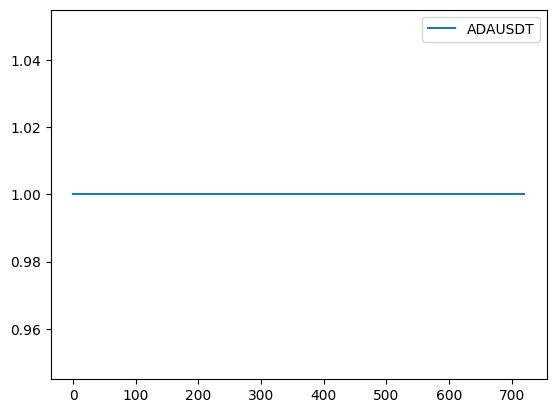

Epoch 10, loss: 0.8527: 100%|██████████| 46/46 [00:00<00:00, 93.59it/s] 


Epoch 10, loss: 0.8574573397636414
{0: tensor(-14.4640), 0.6: tensor(-0.2975), 0.9: tensor(0.), 0.95: tensor(0.), 0.99: tensor(0.)}
{0: tensor(20.8396), 0.6: tensor(27.4152), 0.9: tensor(27.), 0.95: tensor(27.), 0.99: tensor(27.)}
max log money: 0.0
max money: 27.41521644592285


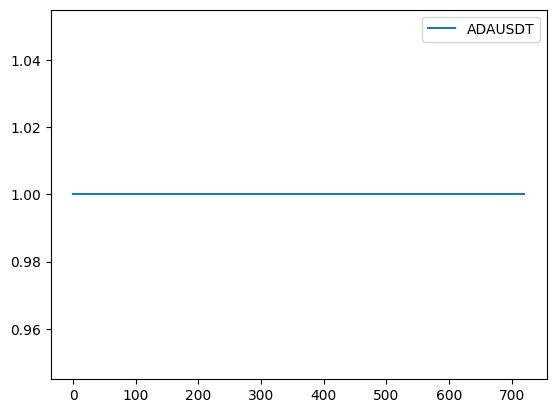

Epoch 20, loss: 0.8177: 100%|██████████| 46/46 [00:00<00:00, 103.02it/s]


Epoch 20, loss: 0.854072093963623
{0: tensor(-8.5969), 0.6: tensor(0.7442), 0.9: tensor(-0.0142), 0.95: tensor(0.), 0.99: tensor(0.)}
{0: tensor(28.6319), 0.6: tensor(28.1966), 0.9: tensor(26.9859), 0.95: tensor(27.), 0.99: tensor(27.)}
max log money: 0.7442172765731812
max money: 28.631900787353516


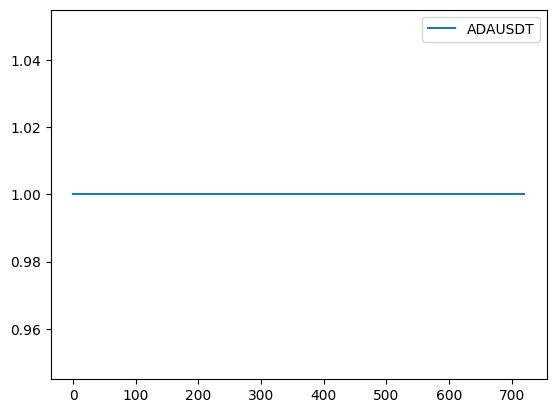

Epoch 30, loss: 0.8383: 100%|██████████| 46/46 [00:00<00:00, 101.37it/s]


Epoch 30, loss: 0.8303974866867065
{0: tensor(-10.5651), 0.6: tensor(0.5045), 0.9: tensor(-0.0142), 0.95: tensor(0.), 0.99: tensor(0.)}
{0: tensor(25.1498), 0.6: tensor(28.3319), 0.9: tensor(26.9859), 0.95: tensor(27.), 0.99: tensor(27.)}
max log money: 0.5044902563095093
max money: 28.331893920898438


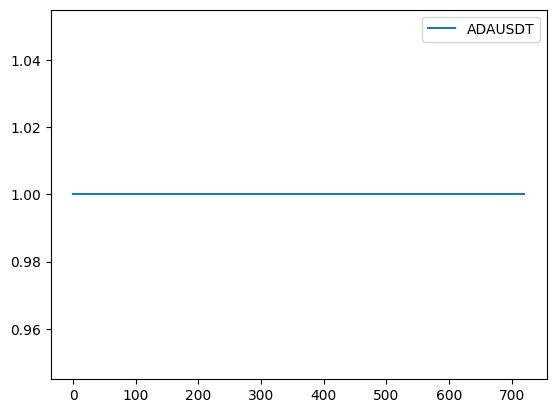

Epoch 39, loss: 0.8103: 100%|██████████| 46/46 [00:00<00:00, 96.00it/s] 


In [103]:
dataset = torch.utils.data.TensorDataset(Xtrain, Ytrain)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

model = TradingNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

best_sum_of_logs = -torch.inf
best_sum = -torch.inf
thresholds = [0, 0.6, 0.9, 0.95, 0.99]
loss = torch.tensor(torch.inf)

for epoch in range(EPOCHS):
    for Xbatch, Ybatch in tqdm(dataloader,
                               f"Epoch {epoch}, loss: {loss.item():.4f}"):
        optimizer.zero_grad()

        Y_pred = model(Xbatch)
        loss = criterion(Y_pred, Ybatch)
        loss.backward()
        optimizer.step()

    if WANDB:
        wandb.log({"loss": loss.item()}, commit=False)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

        model.eval()

        money_sum_of_logs = {t: 0 for t in thresholds}

        money_sum = {t: 0 for t in thresholds}

        for symbol in Xtest_dict:
            Xtest = Xtest_dict[symbol]
            Ytest = Ytest_dict[symbol]
            Yregr = Ytest_regr_dict[symbol]

            money, _, correct_rate = test_run(model, Xtest, Ytest, Yregr,
                                              thresholds, symbol == "BTCUSDT")

            if symbol[0:3] == "ADA":
                plt.plot([m.item() for m in money[0.9]], label=symbol)

            for t in thresholds:
                if WANDB:
                    wandb.log(
                        {
                            f"money_{symbol}_{t}": money[t][-1].item(),
                            f"correct_rate_{symbol}_{t}": correct_rate[t]
                        },
                        commit=False)

                money_sum_of_logs[t] += torch.log(torch.tensor(money[t][-1]))
                money_sum[t] += money[t][-1]

        for t in thresholds:
            if WANDB:
                wandb.log(
                    {
                        f"money_sum_of_logs_{t}": money_sum_of_logs[t].item(),
                        f"money_sum_{t}": money_sum[t].item()
                    },
                    commit=False)

        print(money_sum_of_logs)
        print(money_sum)

        # best sum of logs

        thresholds_arr = list(money_sum_of_logs.keys())
        log_money_arr = list(money_sum_of_logs.values())

        max_idx = max(range(len(log_money_arr)),
                      key=lambda i: log_money_arr[i])
        max_threshold = thresholds_arr[max_idx]
        max_log_money = log_money_arr[max_idx]

        print(f"max log money: {max_log_money}")

        if max_log_money > best_sum_of_logs:
            best_sum_of_logs = max_log_money
            torch.save(
                model.state_dict(),
                f"models/CategoricalBuyOrSellWithFee_BestSumOfLogs-{max_log_money}_threshold-{max_threshold}_epoch-{epoch}_.pt"
            )

        # best sum

        thresholds_arr = list(money_sum.keys())
        money_arr = list(money_sum.values())

        max_idx = max(range(len(money_arr)), key=lambda i: money_arr[i])
        max_threshold = thresholds_arr[max_idx]
        max_money = money_arr[max_idx]

        print(f"max money: {max_money}")

        if max_money > best_sum:
            best_sum = max_money
            torch.save(
                model.state_dict(),
                f"CategoricalBuyOrSellWithFee_BestSum-{max_money}_threshold-{max_threshold}_.pt"
            )

        plt.legend()
        plt.show()

        model.train()

    if WANDB:
        wandb.log({"epoch": epoch})


In [104]:
if WANDB:
    wandb.finish()

In [105]:
torch.log(torch.tensor(-1))

tensor(nan)